# Content and Objective

+ Generating several realizations of a Poisson process
+ Plotting realizations and histogram of "end values" at a given time (thereby demonstrating the central limit theorem)
+ Calculation of acf shows that Poisson processes are not stationary
+ Finally, large observation length is used for demonstrating that theoretical acf and simulated estimation of acf are equal

# Import

In [1]:
# importing
import numpy as np

import shutil

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

matplotlib.rc('figure', figsize=(13, 5) )

# Function for Generating Poisson Processes

In [3]:
# Function for Generating Poisson Processes
def get_Poisson_Process( lamb, t ):
    """
    Function generating a Poisson process by adding-up exponential inter-arrival times
    
    IN:     lamb, parameter of Poisson
            t, vector of time samples
              
    OUT:    X, Poisson process
    """
    
    # initialize max time and event times
    t_max = np.max( t )
    events = [ 0 ]
    
    # loop for generating events such that t_max is being passed
    while events[ -1 ] < t_max:
    
        # now generate random events with exponentially distributed inter-event-times
        # NOTE: We will understand this choice later in this sheet/lecture 
        inter_event = np.random.exponential( 1 / lamb )

        # events by adding the inter-event times, thus generating increasing sequence of "event times"
        events.append( events[ -1 ] + inter_event )

    # initialize process
    X = np.zeros_like( t )
    
    # generating step function out of event times
    for val_event in events:

        # positive step whenever time is larger than event time
        ind = [ int( val_t > val_event ) for val_t in t ]
        
        # adding up all steps
        X += ind 
        
    return X

# Showing a Single Realization of a Poisson Process

In [4]:
# Poisson parameter
lamb = 1

# observation time of realization
t_max = 30

# sample time and time vector
t_sample = .01
t = np.arange( 0, t_max, t_sample )

len_sequence = int( np.max( t ) ) + 1

X_Poisson_new = np.zeros( int( t_max / t_sample ) ) 

# get realization of Poisson process
X_Poisson_new[ : ] = get_Poisson_Process( lamb, t )

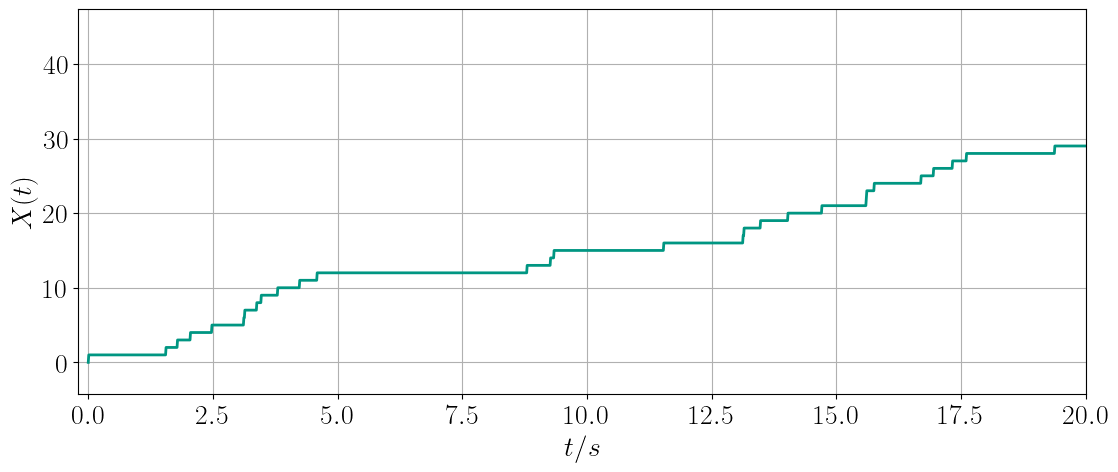

In [5]:
# plotting
plt.plot( t, X_Poisson_new[ : ], c=(0,0.59,0.51), linewidth = 2.0 )    

plt.grid( True )
plt.xlabel('$t/s$')
plt.ylabel('$X(t)$')
plt.margins(.1)
plt.xlim( (-0.2,20) )
plt.show()
#plt.savefig('Poisson_sim.pdf', bbox_inches='tight')

# Showing a Bunch of Realizations for a Poisson Process

In [6]:
# Poisson parameter
lamb = 1

# observation time of realization
t_max = 20

# sample time and time vector
t_sample = .01
t = np.arange( 0, t_max, t_sample )

len_sequence = int( np.max( t ) ) + 1

# define number of sequences to be simulated
# NOTE: increase N_sequences if multiple realization should be plotted
N_sequences = 1000

# initialize field for storing multiple process realizations
X_Poisson_new = np.zeros( ( N_sequences, int( t_max / t_sample ) ) )

# loop for realizations
for n in range( N_sequences ):
    
    # get realizations of Poisson process
    X_Poisson_new[ n, : ] = get_Poisson_Process( lamb, t )

Using matplotlib backend: inline


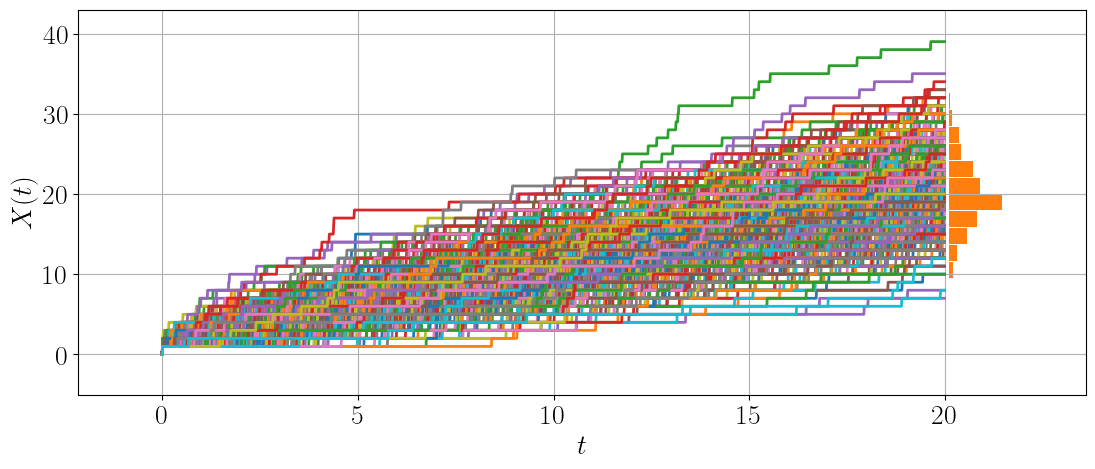

In [7]:
# plotting
%matplotlib
for n in np.arange( N_sequences ): 
    plt.plot( t, X_Poisson_new[ n, :], linewidth = 2.0 )    

plt.grid( True )
plt.xlabel('$t$')
plt.ylabel('$X(t)$')
plt.margins(.1)


# extract end-points at final time
results_end = X_Poisson_new[ : , -1 ]

# get histogram
num_bins = 20
width = 2
bins = np.linspace(0, 40, num_bins, endpoint=True)
r_hist = np.histogram( results_end, bins = bins, density = True )

plt.barh( r_hist[1][:-1], 0 + r_hist[0] / np.sum(r_hist[0]) * 5 , width, left=len_sequence+0.1, color = '#ff7f0e' )
plt.show()

<b>Discussion:</b> The histogram on the right hand side again looks like gaussian?! Can you explain?

# Get ACF for Processes

<b>NOTE:</b> Since we don't know about stationarity of the process yet, acf may be depending on $t$ and $\tau$

In [8]:
# number of trials and samples
N_trials = int( 1e2 )
N_time_samples = int( t_max / t_sample )

# Decrease length
t_max = 10

# sample time and time vector
t_sample = .1
t = np.arange( 0, t_max, t_sample )

# initialized acf
# NOTE: for simplification of simulation, only positive indices are simulated and acf is adapted accordingly
tau_acf = np.arange( - t_max, t_max + t_sample, t_sample)
tau_acf_pos = np.arange( 0, t_max + t_sample, t_sample)

# initialize empty two-dim array (t and tau)
acf_2d = np.zeros( ( len(t), len(tau_acf) ) )

# initialize field for storing multiple processes
X_Poisson = np.zeros( ( N_trials, int( 3 * t_max / t_sample ) ) )

# loop for realizations
for n in range( N_trials ):
    
    # get realizations of Poisson process
    # NOTE: zeros are padded in order to avoid border effects
    X_Poisson[ n, : len(t) ] = get_Poisson_Process( lamb, t )

    
# loop for all times
for ind_t, val_t in enumerate( t ):

    # loop for all delays
    for ind_tau, val_tau in enumerate( tau_acf_pos ):

        # get acf at according index/time/delay
        corr = [ X_Poisson[ _n, ind_t + ind_tau ] 
                    * X_Poisson[ _n, ind_t ]
                    for _n in range( N_trials ) ]                   
        
        # assign acf
        # NOTE: Negative shifts are given by acf( -tau ) = acf( tau ) for real-valued processes
        acf_2d[ ind_t, + ind_tau + len(t) ] = np.sum( corr ) / N_trials 
        acf_2d[ ind_t, - ind_tau + len(t) ] = np.sum( corr ) / N_trials 

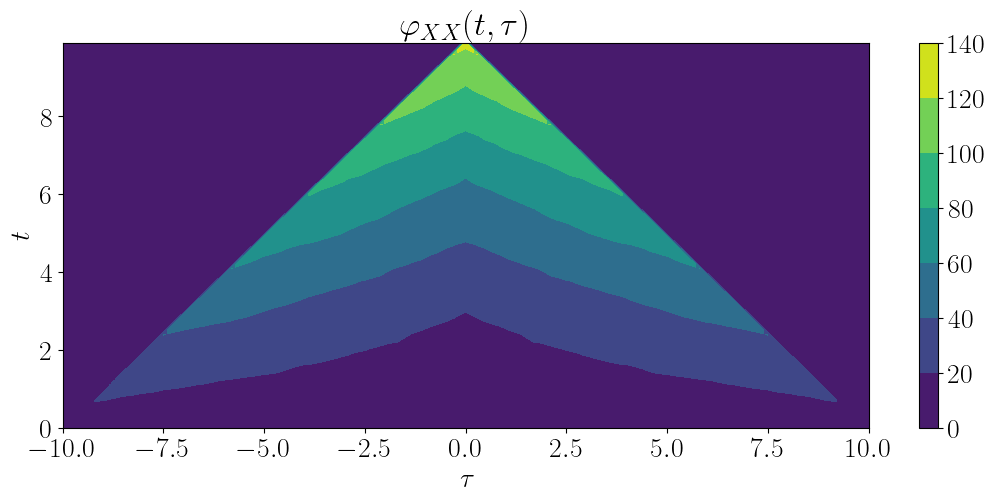

In [9]:
# parameters for meshing
T, Tau_acf = np.meshgrid( tau_acf, t )

# plotting
plt.contourf( T, Tau_acf , acf_2d[ : , : ] )

plt.xlabel('$\\tau$')
plt.ylabel('$t$')
plt.title('$\\varphi_{XX}(t,\\tau)$')
plt.colorbar()

<b>Discussion:</b> 
- Is this what you expected?
- If not, can you explain why it is different?!

### Increase observation/window length to alleviate effects of clipping and windowing; compare with theoretical acf

<b>Exercise:</b> Derive the theoretical result.

In [10]:
# number of trials and samples
N_trials = int( 1e2 )
N_time_samples = int( t_max / t_sample )

# Decrease length
t_max = 10

# sample time and time vector
t_sample = .1
t = np.arange( 0, t_max, t_sample )
t_large = np.arange( 0, 5 * t_max, t_sample )


# initialized acf
# NOTE: for simplification of simulation, only positive indices are simulated and acf is adapted accordingly
tau_acf = np.arange( - t_max, t_max + t_sample, t_sample)
tau_acf_pos = np.arange( 0, t_max + t_sample, t_sample)

# initialize empty two-dim array (t and tau)
acf_2d = np.zeros( ( len(t), len(tau_acf) ) )
acf_theo = np.zeros( ( len(t), len(tau_acf) ) )

# initialize field for storing multiple processes
X_Poisson = np.zeros( ( N_trials, int( 6 * t_max / t_sample ) ) )

# loop for realizations
for n in range( N_trials ):
    
    # get realizations of Poisson process
    # NOTE: zeros are padded in order to avoid border effects
    X_Poisson[ n, : len(t_large) ] = get_Poisson_Process( lamb, t_large )

    
# loop for all times
for ind_t, val_t in enumerate( t ):

    # loop for all delays
    for ind_tau, val_tau in enumerate( tau_acf_pos ):

        # get acf at according index/time/delay
        corr = [ X_Poisson[ _n, ind_t + ind_tau ] 
                    * X_Poisson[ _n, ind_t ]
                    for _n in range( N_trials ) ]                   
        
        # assign acf
        # NOTE: Negative shifts are given by acf( -tau ) = acf( tau ) for real-valued processes
        acf_2d[ ind_t, + ind_tau + len(t) ] = np.sum( corr ) / N_trials 
        acf_2d[ ind_t, - ind_tau + len(t) ] = np.sum( corr ) / N_trials 
        
        acf_theo[ ind_t, + ind_tau + len(t) ] = val_t * ( val_t + 1 + val_tau )
        acf_theo[ ind_t, - ind_tau + len(t) ] = val_t * ( val_t + 1 + val_tau )        

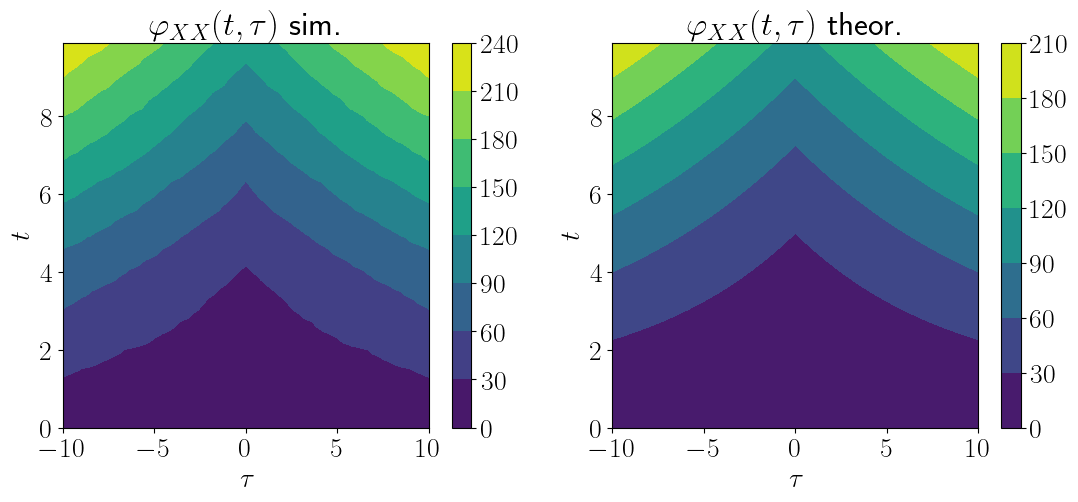

In [11]:
# parameters for meshing
T, Tau_acf = np.meshgrid( tau_acf, t )

# plotting
plt.subplot(121)
plt.contourf( T, Tau_acf , acf_2d[ : , : ] )

plt.xlabel('$\\tau$')
plt.ylabel('$t$')
plt.title('$\\varphi_{XX}(t,\\tau)$ sim.')
plt.colorbar()

plt.subplot(122)
plt.contourf( T, Tau_acf, acf_theo )

plt.xlabel('$\\tau$')
plt.ylabel('$t$')
plt.title('$\\varphi_{XX}(t,\\tau)$ theor.')
plt.colorbar()